In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
dataSets = input_data.read_data_sets("/Users/urim/DATA/MNIST_data/", one_hot=True)

Extracting /Users/urim/DATA/MNIST_data/train-images-idx3-ubyte.gz
Extracting /Users/urim/DATA/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /Users/urim/DATA/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /Users/urim/DATA/MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
batch_size = 64
lr_init_dec = 0.001
lr_init_pred = 0.01
decay_steps = 1000
decay_rate = 0.9
train_steps = 10000
dec_train_steps = int(train_steps*0.8)
printBy = int(train_steps/10)


In [3]:
inputs = tf.placeholder(tf.float32, shape=[batch_size, 28 * 28 * 1])
labels = tf.placeholder(tf.int32, shape=[batch_size, 10])
global_step_dec = tf.Variable(0, name='global_step_dec', trainable=False, dtype=tf.int32)
lr_dec = tf.train.exponential_decay(lr_init_dec, global_step_dec, decay_steps, decay_rate, staircase=True)
global_step_pred = tf.Variable(0, name='global_step_pred', trainable=False, dtype=tf.int32)
lr_pred = tf.train.exponential_decay(lr_init_pred, global_step_pred, decay_steps, decay_rate, staircase=True)

In [4]:
def linear(input_, output_size, scope=None, bias_start=0.0, wd=None, with_w=False):
    shape = input_.get_shape().as_list()
    stddev=1.0/np.sqrt(output_size)
    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32, tf.random_normal_initializer(stddev=stddev))
        #matrix = tf.Variable(tf.truncated_normal([shape[1], output_size], stddev=1.0/np.sqrt(output_size)), name="Matrix")
        if wd is not None:
            _weight_decay = tf.multiply(tf.nn.l2_loss(matrix), wd, name='weigth_loss')
            tf.add_to_collection('loss', _weight_decay)
        bias = tf.get_variable("bias", [output_size], initializer=tf.constant_initializer(bias_start))
        if with_w: return tf.matmul(input_, matrix) + bias, matrix, bias
        else: return tf.matmul(input_, matrix) + bias
        
def Accuracy(pred, true, round=False):
    if round: is_correct = tf.equal(tf.round(pred), true)
    else: is_correct = tf.equal(tf.argmax(pred,1), tf.argmax(true,1))
    return tf.reduce_mean(tf.cast(is_correct, tf.float32))

with tf.variable_scope('ENC') as scope:
    enc1 = tf.nn.sigmoid(linear(inputs, 128, 'enc1'))
    enc2 = tf.nn.sigmoid(linear(enc1, 64, 'enc2'))
    
with tf.variable_scope('DEC') as scope:
    dec1 = tf.nn.sigmoid(linear(enc2, 128, 'dec1'))
    dec_logits = linear(dec1, 28*28*1, 'dec')
    
with tf.variable_scope('PRED') as scope:
    enc2_stop_gd = tf.stop_gradient(enc2)
    pred_logits = linear(enc2_stop_gd, 10, 'pred')
    

In [5]:
with tf.name_scope('DEC_LOSS') as scope:
    dec_loss_batch = tf.nn.sigmoid_cross_entropy_with_logits(logits=dec_logits, labels=inputs)
    dec_loss = tf.reduce_mean(dec_loss_batch)
    
with tf.name_scope('PRED_LOSS') as scope:
    pred_loss_batch = tf.nn.softmax_cross_entropy_with_logits(logits=pred_logits, labels=labels)
    pred_loss = tf.reduce_mean(pred_loss_batch)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [6]:
dec_train_op = tf.train.AdamOptimizer(lr_dec).minimize(dec_loss, global_step=global_step_dec)
pred_train_op = tf.train.AdamOptimizer(lr_pred).minimize(pred_loss, global_step=global_step_pred)
accuracy = Accuracy(tf.nn.softmax(pred_logits), labels)

In [10]:
from tqdm import trange

with tf.Session() as sess:
    tf.train.start_queue_runners(sess=sess)
    tf.global_variables_initializer().run(session=sess)
    #loss_dict = {'train_loss':[], 'val_loss':[]}
    for step in trange(train_steps):
        tr_inputs, tr_labels = dataSets.train.next_batch(batch_size)
        tr_feed_dict = {inputs: tr_inputs, labels: tr_labels}
        
        if step<dec_train_steps:
            _ = sess.run(dec_train_op, feed_dict=tr_feed_dict)
        else:
            if step==dec_train_steps:
                print("\n\n[!] Supervised Learning Starts!!\n\n")
            _ = sess.run(pred_train_op, feed_dict=tr_feed_dict)
        
        if (step+1)%printBy==0:
            val_inputs, val_labels = dataSets.validation.next_batch(batch_size)
            val_feed_dict = {inputs: val_inputs, labels: val_labels}
            
            dec_g_step, tr_lr_dec, dec_tr_loss = sess.run([global_step_dec, lr_dec, dec_loss], feed_dict=tr_feed_dict)
            dec_val_loss = sess.run(dec_loss, feed_dict=val_feed_dict)
            print("DEC-{}: LR({:.6f}), DEC_loss({:.4f}||{:.4f})".format(dec_g_step, tr_lr_dec, dec_tr_loss, dec_val_loss))
            pred_g_step, tr_lr_pred, pred_tr_loss, tr_acc = sess.run([global_step_pred, lr_pred, pred_loss, accuracy], feed_dict=tr_feed_dict)
            pred_val_loss, val_acc = sess.run([pred_loss, accuracy], feed_dict=val_feed_dict)
            print("PRED-{}: LR({:.6f}), PRED_loss({:.4f}||{:.4f}), ACC({:.3f}||{:.3f})"
                  .format(pred_g_step, tr_lr_pred, pred_tr_loss, pred_val_loss, tr_acc, val_acc))
    
    print("\n\n[TEST]")
    test_inputs, test_labels = dataSets.test.next_batch(batch_size)
    test_feed_dict = {inputs: test_inputs, labels: test_labels}
    dec_test_loss, test_recon = sess.run([dec_loss, tf.nn.sigmoid(dec_logits)], feed_dict=test_feed_dict)
    print("DEC_loss({:.4f})".format(dec_test_loss))
    pred_test_loss, test_acc = sess.run([pred_loss, accuracy], feed_dict=test_feed_dict)
    print("PRED_loss({:.4f}), ACC({:.3f})".format(pred_test_loss, test_acc))
            

 11%|█         | 1062/10000 [00:01<00:16, 539.11it/s]

DEC-1000: LR(0.000900), DEC_loss(0.2325||0.2321)
PRED-0: LR(0.010000), PRED_loss(2.6342||2.4429), ACC(0.156||0.219)


 21%|██        | 2077/10000 [00:03<00:14, 562.31it/s]

DEC-2000: LR(0.000810), DEC_loss(0.1803||0.1747)
PRED-0: LR(0.010000), PRED_loss(2.4920||2.8509), ACC(0.234||0.109)


 31%|███       | 3073/10000 [00:05<00:12, 566.59it/s]

DEC-3000: LR(0.000729), DEC_loss(0.1550||0.1553)
PRED-0: LR(0.010000), PRED_loss(3.1012||2.7853), ACC(0.109||0.109)


 40%|████      | 4011/10000 [00:07<00:10, 568.50it/s]

DEC-4000: LR(0.000656), DEC_loss(0.1493||0.1480)
PRED-0: LR(0.010000), PRED_loss(2.9330||2.5949), ACC(0.094||0.188)


 51%|█████     | 5096/10000 [00:09<00:08, 560.32it/s]

DEC-5000: LR(0.000590), DEC_loss(0.1299||0.1311)
PRED-0: LR(0.010000), PRED_loss(2.9085||2.6569), ACC(0.047||0.156)


 61%|██████    | 6104/10000 [00:10<00:06, 564.34it/s]

DEC-6000: LR(0.000531), DEC_loss(0.1320||0.1236)
PRED-0: LR(0.010000), PRED_loss(2.7153||2.8163), ACC(0.125||0.078)


 71%|███████   | 7086/10000 [00:12<00:05, 569.54it/s]

DEC-7000: LR(0.000478), DEC_loss(0.1220||0.1206)
PRED-0: LR(0.010000), PRED_loss(2.6284||2.6005), ACC(0.094||0.125)


 81%|████████  | 8082/10000 [00:14<00:03, 573.50it/s]

DEC-8000: LR(0.000430), DEC_loss(0.1292||0.1191)
PRED-0: LR(0.010000), PRED_loss(3.0177||2.6909), ACC(0.094||0.156)


[!] Supervised Learning Starts!!




 91%|█████████ | 9114/10000 [00:15<00:01, 592.08it/s]

DEC-8000: LR(0.000430), DEC_loss(0.1239||0.1128)
PRED-1000: LR(0.009000), PRED_loss(0.6673||0.3595), ACC(0.797||0.875)


100%|██████████| 10000/10000 [00:16<00:00, 605.52it/s]

DEC-8000: LR(0.000430), DEC_loss(0.1265||0.1068)
PRED-2000: LR(0.008100), PRED_loss(0.4305||0.2494), ACC(0.875||0.922)


[TEST]
DEC_loss(0.1216)
PRED_loss(0.4634), ACC(0.844)


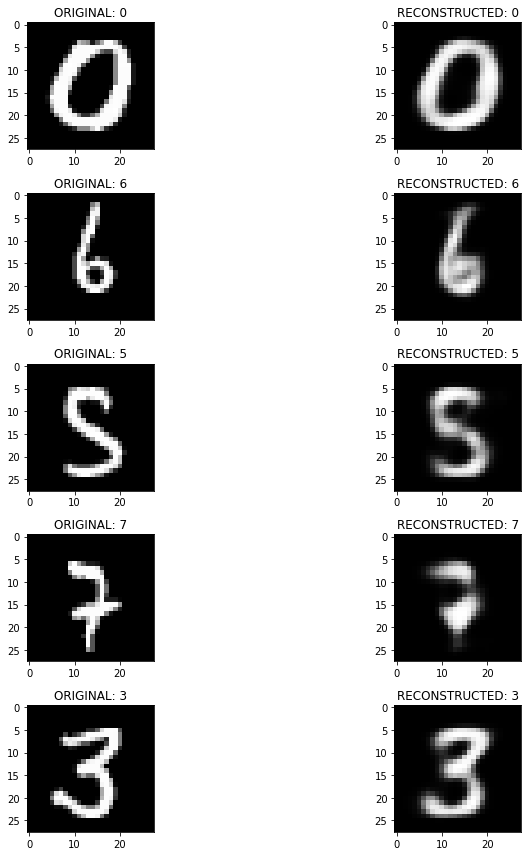

In [11]:
def recon_result_viewer(originals, labels, recons, n_samples=5):
    import numpy as np
    import matplotlib.pyplot as plt
    
    idx_list = np.random.choice(np.arange(len(labels)), size=n_samples, replace=False)
    originals = originals[idx_list]
    labels = labels[idx_list]
    recons = recons[idx_list]

    plt.figure(figsize=(12,12))
    for i in range(n_samples):
        ncol = 2
        nrow = n_samples
        plt.subplot(nrow, ncol, 2*i+1)
        plt.title("ORIGINAL: {}".format(np.argmax(labels[i])))
        plt.tight_layout()
        plt.imshow(originals[i].reshape([28,28]), cmap='gray')

        plt.subplot(nrow, ncol, 2*i+2)
        plt.title("RECONSTRUCTED: {}".format(np.argmax(labels[i])))
        plt.tight_layout()
        plt.imshow(recons[i].reshape([28,28]), cmap='gray')
        
recon_result_viewer(test_inputs, test_labels, test_recon, n_samples=5)